In [66]:
import os
import math
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn import tree

In [53]:
!pip install pmdarima

In [54]:
pip install numba==0.53

  Using cached numba-0.53.0-cp39-cp39-win_amd64.whl (2.3 MB)
  Using cached llvmlite-0.36.0-cp39-cp39-win_amd64.whl (16.0 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.37.0
Note: you may need to restart the kernel to use updated packages.


ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [67]:
#Reading Stores datafile
pd.options.display.max_columns=100
store = pd.read_csv('stores.csv')
store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [68]:
#Checking null columns
store.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

In [69]:
#Reading Features CSV
features=pd.read_csv('features.csv')
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [70]:
#Imputing Unemployment and CPI with mean
features_1=features
features_2 = features_1
features_1['CPI'] =features_1['CPI'].fillna(features_1['CPI'].mean())
features_2['Unemployment'] =features_2['Unemployment'].fillna(features_2['Unemployment'].mean())
features_2.info()
features_2.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           8190 non-null   float64
 10  Unemployment  8190 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
dtype: int64

In [71]:
#Reading Train file
train_data=pd.read_csv('train.csv')
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [72]:
#Merging the three CSVs on "Store" and "Date"
walmart = train_data.merge(features_2, on=['Store', 'Date'], how='inner').merge(store, on=['Store'], how='inner')
walmart.info()
walmart.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  IsHoliday_y   421570 non-null  bool   
 15  Type          421570 non-null  object 
 16  Size          421570 non-null  int64  
dtypes: bool(2), float64(10), int64(3), object(2)
mem

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [73]:
#Dropping duplicate Holiday column
walmart.drop(['IsHoliday_y'], axis=1,inplace=True)

In [74]:
walmart.rename(columns={"IsHoliday_x" : "IsHoliday"},inplace=True)
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [75]:
#Changing dtype of Date
walmart["Date"] = pd.to_datetime(walmart["Date"])
walmart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [76]:
#Locating weekly sales that are less than or equal to 0. Since this is Walmart and the probability of a department 
#not selling anything the entire week is improbable, I got rid of those rows.
walmart.loc[walmart['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


In [77]:
#Got rid of rows where weekly_sales <= 0
walmart = walmart.loc[walmart['Weekly_Sales'] >0]
walmart.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,150181.000000,110904.000000,136651.000000,134518.000000,150929.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,7247.821269,3330.146158,1441.736203,3384.782267,4629.531870,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,8293.028741,9460.395025,9631.968459,6295.136952,5960.171711,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,2240.270000,41.600000,5.100000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [78]:
#Changing Holiday value to boolean. Map function wasn't working for some reason
type_group = {True:1, False: 0}
walmart['IsHoliday'] = walmart['IsHoliday'].replace(type_group)

In [79]:
#Changing type of store to boolean. 
type_group_2 = {'A':1, 'B':2, 'C':3}
walmart['Type'] = walmart['Type'].replace(type_group_2)

In [80]:
#Filling markdown columns with 0s. Markdown do not directly reflect Holidays. A little research into past projects
#threw light on the fact that markdowns can happen regardless of holidays, that they are just promotional events
#such as spring clearance sale, summer sale or so on.
walmart=walmart.fillna(0)

In [81]:
# VIF values
X = walmart[['Store','Dept','Weekly_Sales','IsHoliday','Temperature','Fuel_Price',
             'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Type','Size']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
 
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)    


         feature        VIF
0          Store   4.512400
1           Dept   3.150781
2   Weekly_Sales   1.641012
3      IsHoliday   1.238067
4    Temperature  13.591012
5     Fuel_Price  42.252520
6      MarkDown1   4.768807
7      MarkDown2   1.158128
8      MarkDown3   1.099155
9      MarkDown4   3.752995
10     MarkDown5   1.458984
11           CPI  17.196513
12  Unemployment  19.921181
13          Type  16.078313
14          Size  13.850234


In [82]:
#Holiday dates
#Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
#Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
#Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
#Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13
#After 7-Sep-2012 are in test dataset

# Super bowl dates in train set
walmart.loc[(walmart['Date'] == '2010-02-12')|(walmart['Date'] == '2011-02-11')|(walmart['Date'] == '2012-02-10'),'Super_Bowl'] = True
walmart.loc[(walmart['Date'] != '2010-02-12')&(walmart['Date'] != '2011-02-11')&(walmart['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [83]:
# Labor day dates in train set
walmart.loc[(walmart['Date'] == '2010-09-10')|(walmart['Date'] == '2011-09-09')|(walmart['Date'] == '2012-09-07'),'Labor_Day'] = True
walmart.loc[(walmart['Date'] != '2010-09-10')&(walmart['Date'] != '2011-09-09')&(walmart['Date'] != '2012-09-07'),'Labor_Day'] = False

In [84]:
# Thanksgiving dates in train set
walmart.loc[(walmart['Date'] == '2010-11-26')|(walmart['Date'] == '2011-11-25'),'Thanksgiving'] = True
walmart.loc[(walmart['Date'] != '2010-11-26')&(walmart['Date'] != '2011-11-25'),'Thanksgiving'] = False


In [85]:
#Christmas dates in train set
walmart.loc[(walmart['Date'] == '2010-12-31')|(walmart['Date'] == '2011-12-30'),'Christmas'] = True
walmart.loc[(walmart['Date'] != '2010-12-31')&(walmart['Date'] != '2011-12-30'),'Christmas'] = False

In [86]:
#Holidays to boolean conversion
type_group_3 = {True:1, False:0,}
walmart['Super_Bowl'] = walmart['Super_Bowl'].replace(type_group_3)

In [87]:
walmart['Labor_Day'] = walmart['Labor_Day'].replace(type_group_3)

In [88]:
walmart['Thanksgiving'] = walmart['Thanksgiving'].replace(type_group_3)

In [89]:
walmart['Christmas'] = walmart['Christmas'].replace(type_group_3)
walmart

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0,0,0,0
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0,0,0,0
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0,0,0,0
3,1,4,2010-02-05,39954.04,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0,0,0,0
4,1,5,2010-02-05,32229.38,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,0,0,0,0
421566,45,94,2012-10-26,5203.31,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,0,0,0,0
421567,45,95,2012-10-26,56017.47,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,0,0,0,0
421568,45,97,2012-10-26,6817.48,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,0,0,0,0


In [90]:
# #def get_category(Super_Bowl,Thanksgiving,Labor_Day,Christmas):
#     if Super_Bowl ==1 and Thanksgiving == 0 and Labor_Day == 0 and Christmas == 0:
#         return 'Superbowl'
#     elif Super_Bowl ==0 and Thanksgiving == 1 and Labor_Day == 0 and Christmas == 0:
#         return 'Thanksgiving'
#     elif Super_Bowl == 0 and Thanksgiving == 0 and Labor_Day == 1 and Christmas == 0:
#         return 'Labor Day'
#     elif Super_Bowl == 0 and Thanksgiving == 0 and Labor_Day == 0 and Christmas == 1:
#         return 'Christmas'
#     elif Super_Bowl ==0 and Thanksgiving == 0 and Labor_Day == 0 and Christmas == 0:
#         return 'Not a Holiday'

# walmart['Holiday Type'] = walmart.apply(lambda walmart:get_category(walmart['Super_Bowl'],walmart['Thanksgiving'],walmart['Labor_Day'],walmart['Christmas']),axis=1)


In [91]:
#Extracting week, year and month from date
walmart["Date"] = pd.to_datetime(walmart["Date"]) # convert to datetime
walmart['week'] =walmart['Date'].dt.week
walmart['month'] =walmart['Date'].dt.month 
walmart['year'] =walmart['Date'].dt.year

C:\Users\mvanu\AppData\Local\Temp/ipykernel_13340/1616237091.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  walmart['week'] =walmart['Date'].dt.week


In [30]:
walmart.shape

(420212, 23)

<AxesSubplot:>

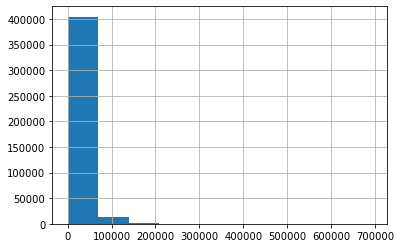

In [244]:
walmart['Weekly_Sales'].hist()

In [245]:
#walmart.to_csv(r'C:\Users\mvanu\Downloads\Walmart_without_zeroes_2.csv', index = False)

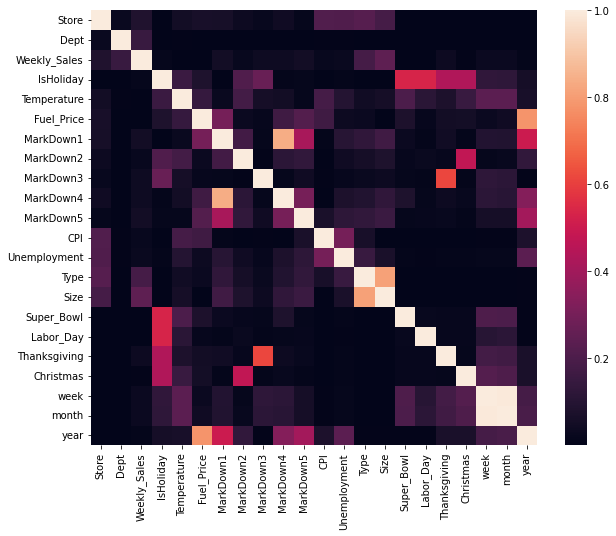

In [27]:
plt.figure(figsize = (10,8))
sns.heatmap(walmart.corr().abs())    # To see the correlations
plt.show()

In [247]:
#Feature selection - 
#markdown 3 highly correlated with thanksgiving.
#Markdown 1 highly correlated with markdown 4
#Size and Type highly correlated
#Fuel-price correlated with year
#Removing Markdown 3, Markdown 4, Size for one model and then type to check if model improves, fuel-price

In [1]:
walmart.shape()

NameError: name 'walmart' is not defined

In [92]:
walmart_og=walmart
walmart_og.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
3,1,4,2010-02-05,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
4,1,5,2010-02-05,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010


In [176]:
walmart=walmart_og
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
3,1,4,2010-02-05,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
4,1,5,2010-02-05,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010


In [93]:
walmart_y=walmart['Weekly_Sales']

In [94]:
walmart=walmart.drop(['MarkDown3','MarkDown4','Size','Fuel_Price','month','Unemployment'],axis=1)

In [95]:
walmart=walmart.drop(['Weekly_Sales'],axis=1)

In [96]:
walmart=walmart.drop(['Date'],axis=1)

In [97]:
walmart=walmart.drop(['Super_Bowl','Labor_Day','Christmas'],axis=1)

In [98]:
walmart=walmart.drop(['Temperature'],axis=1)

In [99]:
walmart=walmart.drop(['year'],axis=1)

In [100]:
scaler = RobustScaler()
walmart_rs = scaler.fit_transform(walmart)

In [101]:
walmart.head()

,Store,Dept,IsHoliday,MarkDown1,MarkDown2,MarkDown5,CPI,Type,Thanksgiving,week
0,1,1,0,0.0,0.0,0.0,211.096358,1,0,5
1,1,2,0,0.0,0.0,0.0,211.096358,1,0,5
2,1,3,0,0.0,0.0,0.0,211.096358,1,0,5
3,1,4,0,0.0,0.0,0.0,211.096358,1,0,5
4,1,5,0,0.0,0.0,0.0,211.096358,1,0,5


In [102]:
walmart_rs = pd.DataFrame(walmart_rs,columns=['Store','Dept','IsHoliday','MarkDown1','MarkDown2','MarkDown5','CPI','Type','Thanksgiving','week'])

In [103]:
#Train features
X_train=walmart_rs
Y_train=walmart_y

In [104]:
# Using Skicit-learn to split data into training and testing sets

X_train, x_test, Y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

In [40]:
Y_train.describe()

count    294148.000000
mean      16018.063124
std       22723.192404
min           0.010000
25%        2115.185000
50%        7675.610000
75%       20265.970000
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [105]:
#The holidays have a 5times more weighted error than non-holidays. I wrote a function to calculate the error based on
#the formula given by walmart's competition in the question
def wmae_test(test, pred): # WMAE for test 
    weights = x_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [42]:
# #Random Forest Regressor hyperparameter tuning
# rfr = rf(random_state = 1)
# params_rf = {'n_estimators': [50,100],
#              'max_depth': [30,40],
#              'min_samples_leaf': [5,10],
#              'max_features': ['sqrt','log','sqrt'],
#              }
# grid_rf = GridSearchCV(estimator=rfr,                       
#                        param_grid=params_rf,                        
#                        cv=2,                       
#                        scoring='neg_mean_squared_error',                       
#                        verbose=10,                       
#                        n_jobs=-1)
# grid_rf.fit(X_train, Y_train)


In [220]:
rfr = rf(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                            max_features = 'sqrt',min_samples_split = 10)


In [221]:
# predictions on train set
rfr.fit(X_train,Y_train)
y_pred = rfr.predict(X_train)

In [222]:
# predictions on test set
y_pred_test = rfr.predict(x_test)
rfr_wmae=wmae_test(y_test,y_pred_test)
print(rfr_wmae)

1303.347197986978


In [191]:
X=walmart_rs

Feature ranking:
1. feature 1 (0.715656)
2. feature 0 (0.091934)
3. feature 7 (0.074150)
4. feature 6 (0.053347)
5. feature 12 (0.026220)
6. feature 5 (0.012098)
7. feature 3 (0.011436)
8. feature 4 (0.007355)
9. feature 13 (0.003214)
10. feature 10 (0.001611)
11. feature 2 (0.001298)
12. feature 11 (0.000793)
13. feature 8 (0.000466)
14. feature 9 (0.000422)


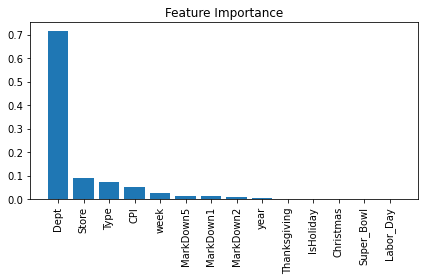

In [195]:
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

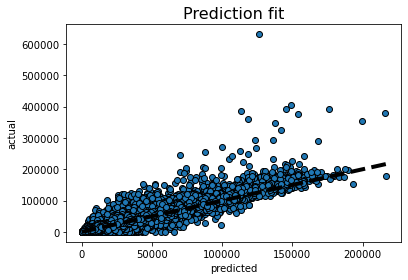

In [224]:
fig, ax = plt.subplots()
plt.title('Prediction fit',fontsize=16)
ax.scatter(y_pred_test, y_test, edgecolors=(0, 0, 0))
ax.plot([y_pred_test.min(), y_pred_test.max()], [y_pred_test.min(), y_pred_test.max()], 'k--', lw=4)
ax.set_xlabel('predicted')
ax.set_ylabel('actual')
plt.show()

In [197]:
rf_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
rf_df.head()

,Actual,Predicted
49549,4524.05,4688.355485
87526,30175.46,44095.062502
295163,453.00,1736.321347
164168,19695.72,19904.792289
62731,16062.30,7225.513427


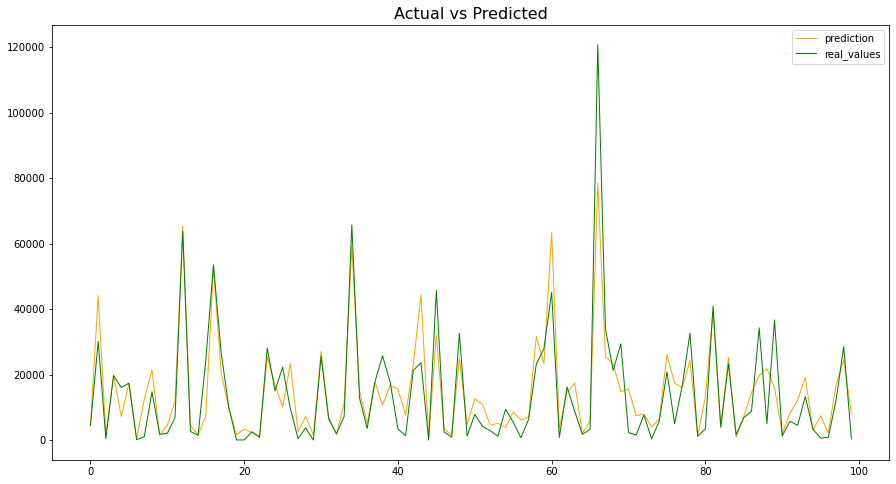

In [203]:
plt.figure(figsize=(15,8))
plt.title('Actual vs Predicted',fontsize=16)
plt.plot(rfr.predict(x_test[:100]), label="prediction", linewidth=1.0,color='orange')
plt.plot(y_test[:100].values, label="real_values", linewidth=1.0,color='green')
plt.legend(loc="best")
# plt.savefig('rf_real_pred.png')
plt.show()

In [ ]:
#Timeseries model
wts=walmart_og

In [ ]:
series.info()

In [ ]:
series=wts[['Date','Weekly_Sales']]
series.set_index('Date', inplace=True)

In [ ]:
fig,ax=plt.subplots(figsize=(12,6))
series.plot('Date','Weekly_Sales',ax=ax)
ax.set(title='Time series')

In [ ]:
series_week = series.resample('W').mean()

In [ ]:
plt.figure(figsize=(12,6))
series_week['Weekly_Sales'].plot()
plt.show()

In [ ]:
series_month = series.resample('MS').mean()
plt.figure(figsize=(12,6))
series_month['Weekly_Sales'].plot()
plt.show()

In [ ]:
walmart_og=walmart

In [ ]:
walmart.head()

In [ ]:
walmart_y=walmart['Weekly_Sales']

In [ ]:
walmart_date=walmart['Date']

In [ ]:
walmart.drop(['Weekly_Sales','Date'],axis=1,inplace=True)

In [ ]:
walmart.drop(['MarkDown3','MarkDown4','Size','Fuel_Price'],axis=1,inplace=True)

In [ ]:
scaler = RobustScaler()
walmart_rs = scaler.fit_transform(walmart)

In [ ]:
walmart.head()

In [ ]:
walmart_rs = pd.DataFrame(walmart_rs,columns=['Store','Dept','IsHoliday','Temperature','MarkDown1','MarkDown2','MarkDown5','CPI','Unemployment','Type','Super_Bowl','Labor_Day','Thanksgiving','Christmas','week','month','year'])

In [ ]:
X_train.drop(['month'],axis=1,inplace=True)
x_test.drop(['month'],axis=1,inplace=True)

In [ ]:
X_train.drop(['Super_Bowl','Labor_Day','Christmas','year'],axis=1,inplace=True)
x_test.drop(['Super_Bowl','Labor_Day','Christmas','year'],axis=1,inplace=True)

In [ ]:
X_train.drop(['Temperature'],axis=1,inplace=True)
x_test.drop(['Temperature'],axis=1,inplace=True)

In [ ]:
X_train,x_test=np.split(walmart_rs, [int(.67 *len(walmart_rs))])

In [ ]:
Y_train,y_test=np.split(walmart_y,[int(.67 *len(walmart_y))])

In [ ]:
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

In [ ]:
rfr = rf(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                            max_features = 'sqrt',min_samples_split = 10)
#rfr1 = rf(n_estimators=100, random_state=42, n_jobs=-1, max_depth=40,
#                            max_features = 'sqrt',min_samples_split = 8)

In [ ]:
# predictions on train set
rfr.fit(X_train,Y_train)
y_pred = rfr.predict(X_train)

In [ ]:
# predictions on test set
y_pred_test = rfr.predict(x_test)
wmae_test(y_test,y_pred_test)

In [ ]:
X=walmart_rs

In [ ]:
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), walmart_rs.columns)
plt.xlim([-1, X.shape[1]])
plt.show()

In [46]:
LR_reg = LinearRegression()
# predictions on train set
LR_reg.fit(X_train,Y_train)
y_pred = LR_reg.predict(X_train)

In [47]:
# predictions on test set
y_pred_test = LR_reg.predict(x_test)
wmae_LR=wmae_test(y_test,y_pred_test)

In [48]:
DT_reg = DecisionTreeRegressor(max_depth=12,min_samples_leaf=3,random_state=1,max_features=7) 
DT_reg.fit(X_train,Y_train)
y_pred = DT_reg.predict(X_train)

In [49]:
# predictions on test set
y_pred_test = DT_reg.predict(x_test)
wmae_DT=wmae_test(y_test,y_pred_test)
print(wmae_DT)

2127.7389655832862


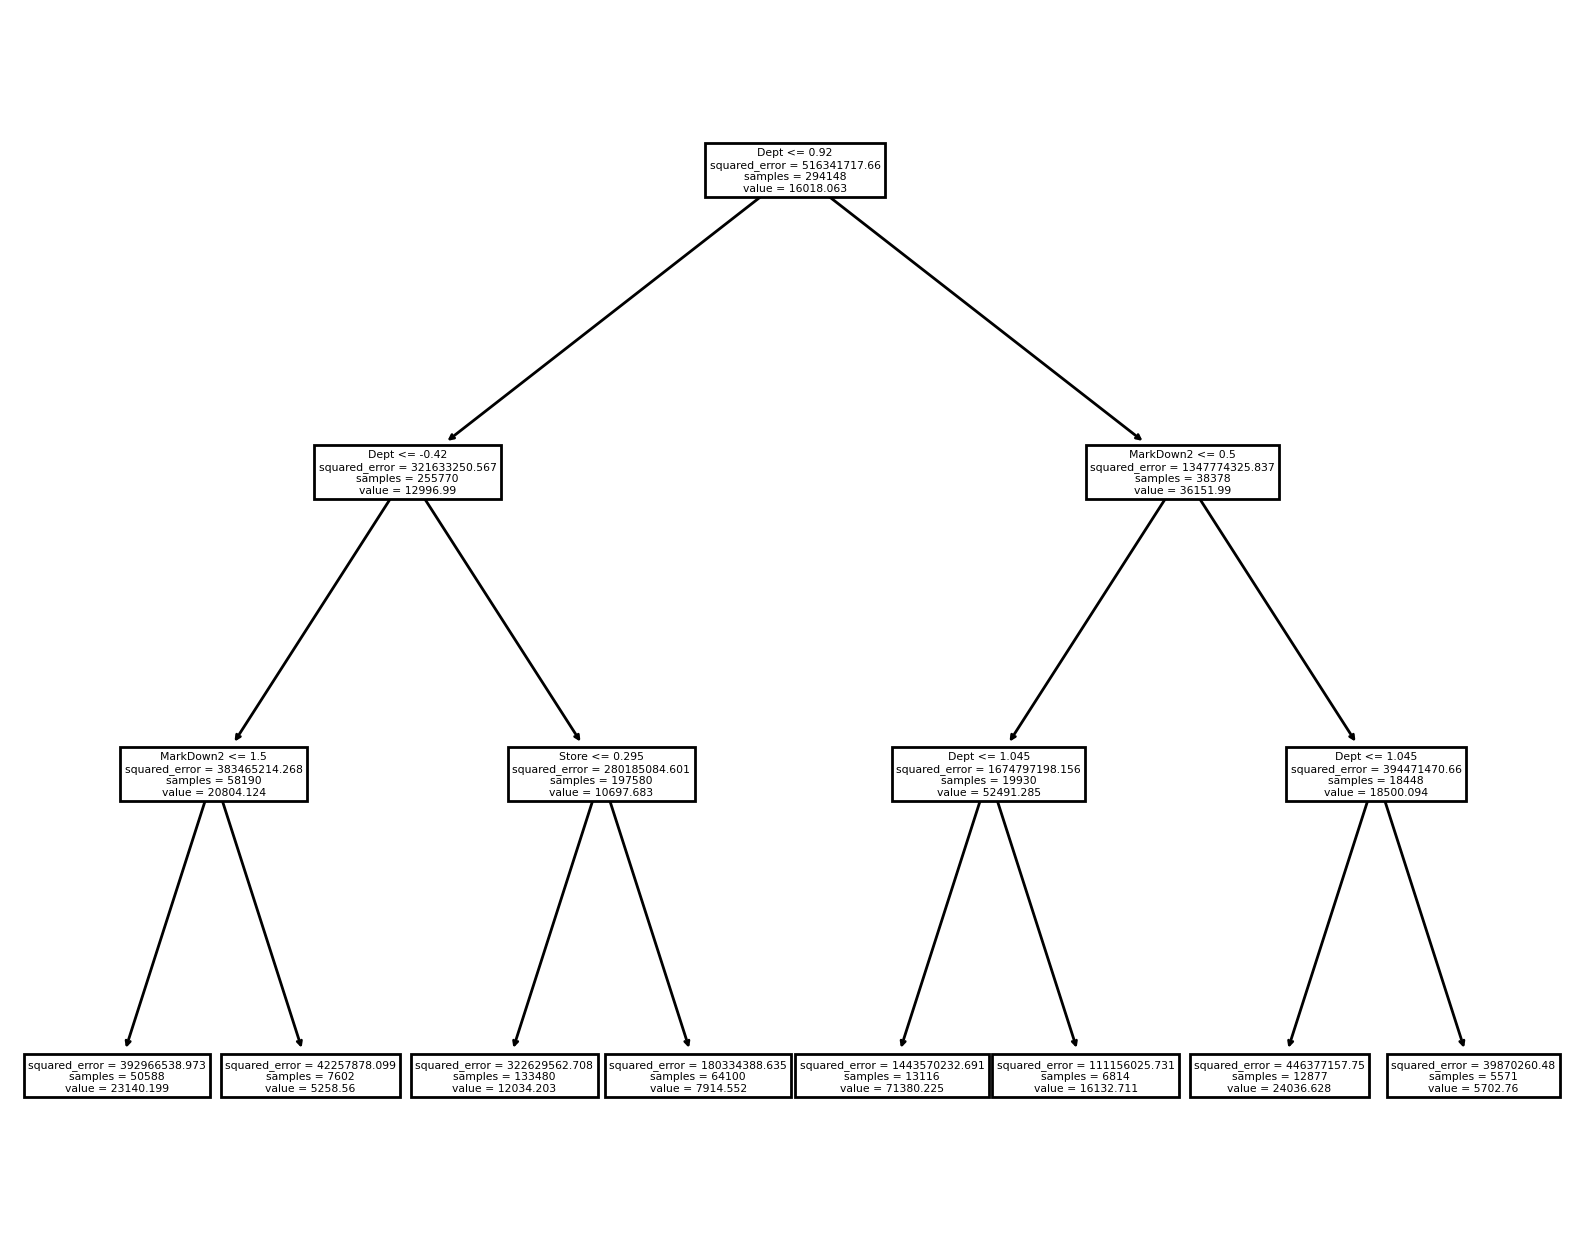

In [313]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,8), dpi=200)
plot_tree(DT_reg, feature_names=X.columns);

In [106]:
ridge_regr=Ridge(alpha=10)
ridge_regr.fit(X_train, Y_train)
y_pred = ridge_regr.predict(X_train)
y_pred_test = ridge_regr.predict(x_test)
wmae_test(y_test,y_pred_test)

4503.172166018644

In [107]:
lasso_regr=Lasso(alpha=80)
lasso_regr.fit(X_train, Y_train)
y_pred = lasso_regr.predict(X_train)
y_pred_test = lasso_regr.predict(x_test)
wmae_test(y_test,y_pred_test)

4501.3612174951995

In [233]:
XGB_regr=XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)
XGB_regr.fit(X_train, Y_train)
y_pred = XGB_regr.predict(X_train)
y_pred_test = XGB_regr.predict(x_test)
wmae_test(y_test,y_pred_test)

440.8655473751236

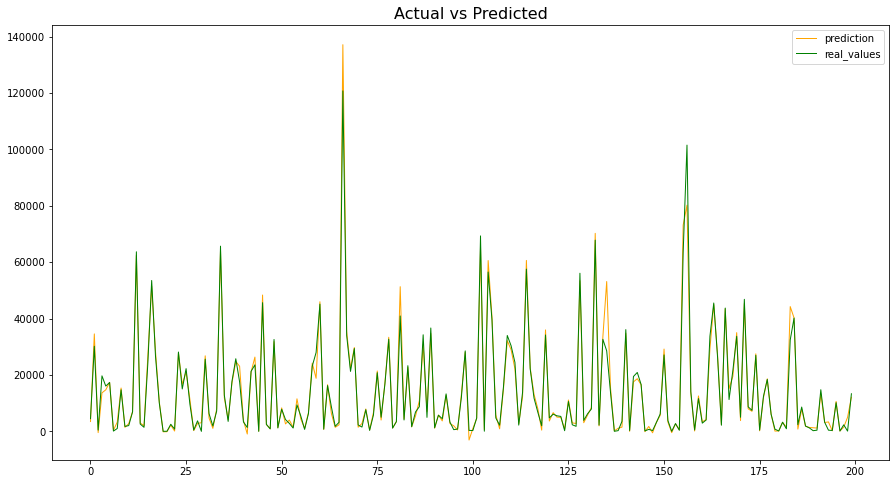

In [231]:
plt.figure(figsize=(15,8))
plt.title('Actual vs Predicted',fontsize=16)
plt.plot(XGB_regr.predict(x_test[:200]), label="prediction", linewidth=1.0,color='orange')
plt.plot(y_test[:200].values, label="real_values", linewidth=1.0,color='green')
plt.legend(loc="best")
#plt.savefig('plots/xgb_real_pred.png')
plt.show()

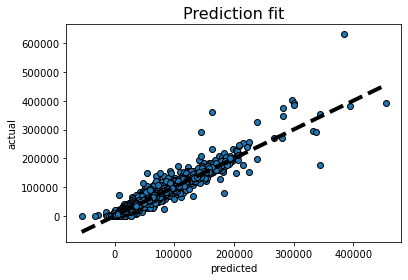

In [234]:
fig, ax = plt.subplots()
plt.title('Prediction fit',fontsize=16)
ax.scatter(y_pred_test, y_test, edgecolors=(0, 0, 0))
ax.plot([y_pred_test.min(), y_pred_test.max()], [y_pred_test.min(), y_pred_test.max()], 'k--', lw=4)
ax.set_xlabel('predicted')
ax.set_ylabel('actual')
plt.show()

In [ ]:
X_train.describe()

In [ ]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': XGB_regr.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [165]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train,Y_train)
y_pred = knn.predict(x_test)
wmae_test(y_test,y_pred)

3297.1518080189153

In [166]:
etr = ExtraTreesRegressor(n_estimators=30,n_jobs=4) 
etr.fit(X_train,Y_train)
y_pred=etr.predict(x_test)
wmae_test(y_test,y_pred)

486.7637402476563

In [31]:
rfr_score=rfr.score(x_test,y_test)
print(rfr_score)

NameError: name 'rfr' is not defined

In [168]:
XGB_score=XGB_regr.score(x_test,y_test)
print(XGB_score)

0.9818358297705675


In [169]:
DT_score=DT_reg.score(x_test,y_test)
print(DT_score)

0.754186142900868


In [170]:
KNN_score=knn.score(x_test,y_test)
print(KNN_score)

0.38892817153744863


In [172]:
ridge_score=ridge_regr.score(x_test,y_test)
print(ridge_score)

0.06400833212333212


In [173]:
etr_score=etr.score(x_test,y_test)
print(etr_score)

0.9697950861093488


In [171]:
LR_score=LR_reg.score(x_test,y_test)
print(LR_score)

0.06400873892238323


In [88]:
walmart=walmart_og
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
3,1,4,2010-02-05,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
4,1,5,2010-02-05,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010


<AxesSubplot:title={'center':'Weekly_Sales'}, xlabel='Date'>

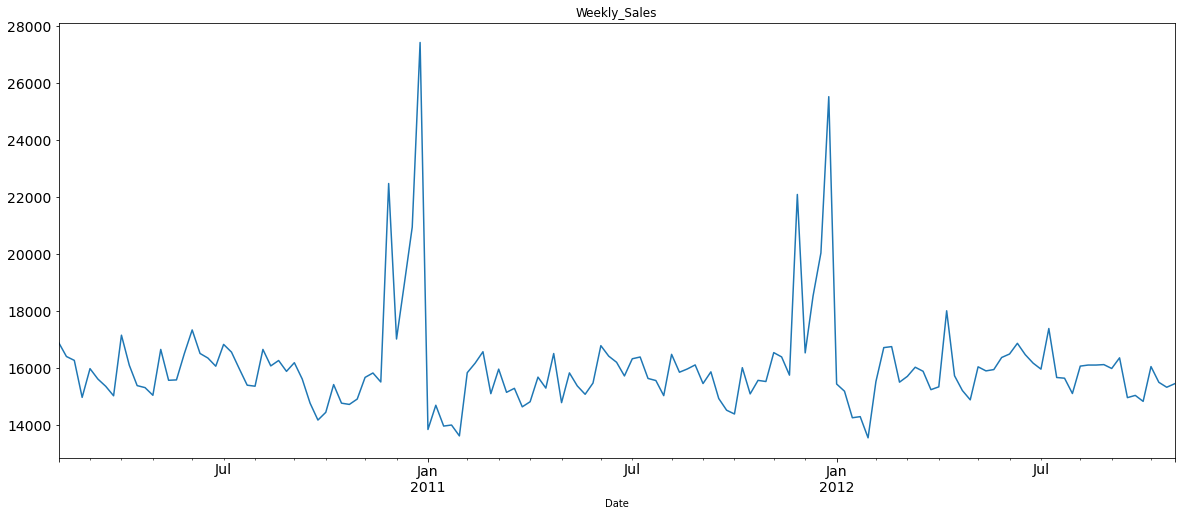

In [91]:
walmart=walmart.resample('W').mean()
walmart['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)

In [90]:
walmart.set_index('Date', inplace=True)

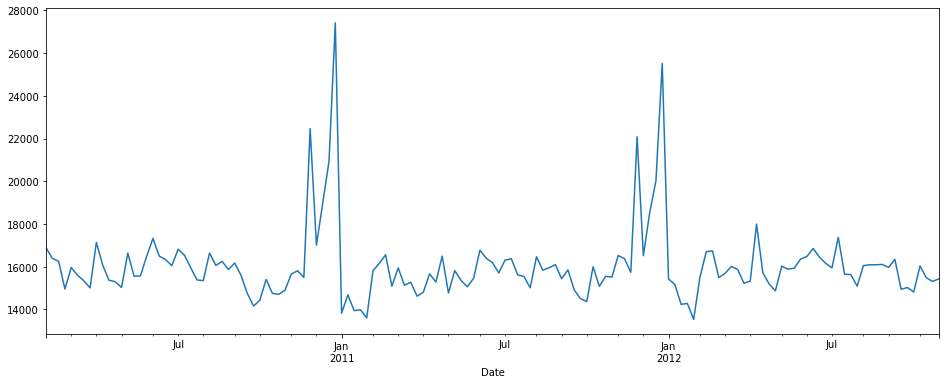

In [121]:
plt.figure(figsize=(16,6))
walmart['Weekly_Sales'].plot()
plt.show()

In [97]:
train_data = walmart[:int(0.7*(len(walmart)))] 
test_data = walmart[int(0.7*(len(walmart))):]

In [98]:
target = "Weekly_Sales"
used_cols = [c for c in walmart.columns.to_list() if c not in [target]]

X_train = train_data[used_cols]
x_test = test_data[used_cols]
Y_train = train_data[target]
y_test = test_data[target]

In [99]:
df_week_diff=walmart['Weekly_Sales'].diff().dropna()

In [237]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [240]:
test_data_diff.shape

(43,)

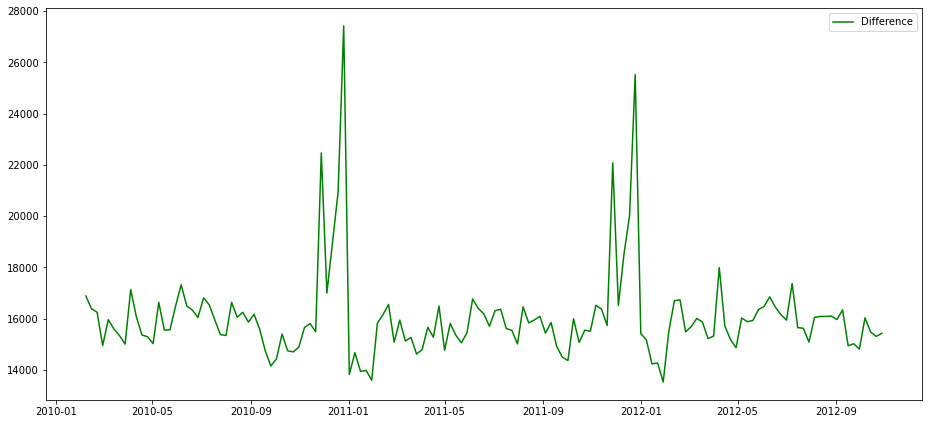

In [101]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(walmart['Weekly_Sales'], color='green',label='Difference')
ax.legend()
fig.tight_layout()

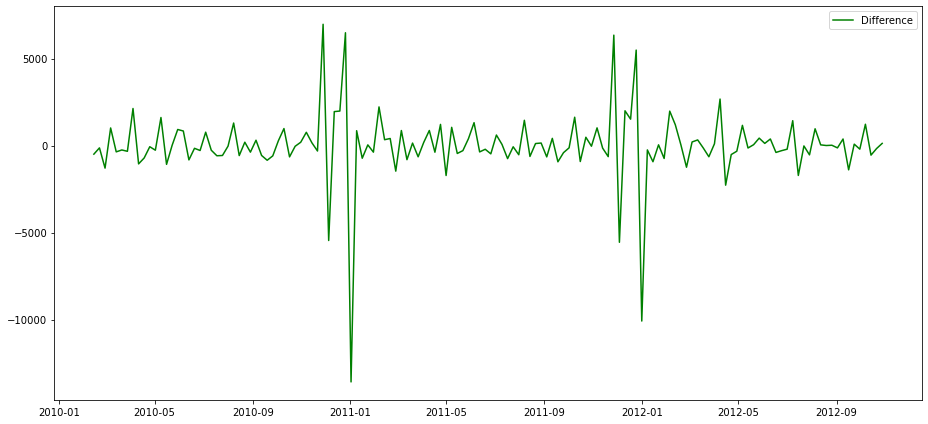

In [102]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='green',label='Difference')
ax.legend()
fig.tight_layout()

In [169]:
adfuller(df_week_diff)

(-6.67488360369857,
 4.4912296815330935e-09,
 7,
 134,
 {'1%': -3.480118600110386,
  '5%': -2.8833618426136196,
  '10%': -2.578407034974382},
 2262.926314647238)

In [235]:
model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

In [129]:
len(test_data_diff)

43

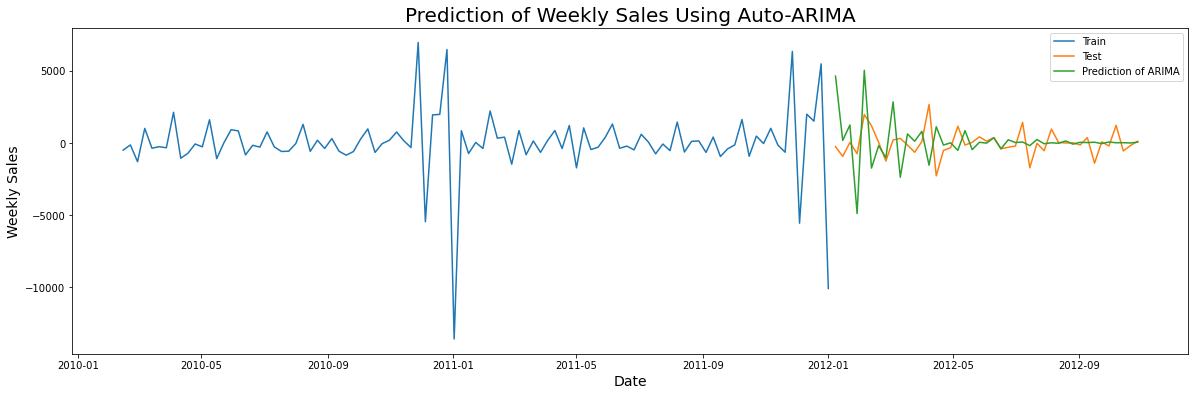

In [236]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [179]:
diff=y_pred['Prediction'] - y_test
wmae_test(y_pred['Prediction'],y_test)

15901.573594574927

In [174]:
y_test.describe

<bound method NDFrame.describe of Date
2012-01-08    15172.381502
2012-01-15    14240.431552
2012-01-22    14279.630241
2012-01-29    13535.547791
2012-02-05    15511.884823
2012-02-12    16703.472478
2012-02-19    16738.021167
2012-02-26    15489.637807
2012-03-04    15693.684826
2012-03-11    16014.393926
2012-03-18    15872.204816
2012-03-25    15226.518413
2012-04-01    15326.020460
2012-04-08    17996.123801
2012-04-15    15716.104725
2012-04-22    15196.634396
2012-04-29    14869.835139
2012-05-06    16028.727724
2012-05-13    15885.859584
2012-05-20    15932.240504
2012-05-27    16356.881537
2012-06-03    16478.487007
2012-06-10    16853.811124
2012-06-17    16455.669143
2012-06-24    16158.774298
2012-07-01    15947.071632
2012-07-08    17374.110380
2012-07-15    15653.784727
2012-07-22    15629.411697
2012-07-29    15091.508648
2012-08-05    16053.456116
2012-08-12    16090.911806
2012-08-19    16090.857333
2012-08-26    16106.388534
2012-09-02    15970.176590
2012-09-09    16

C:\Users\mvanu\AppData\Local\Temp/ipykernel_3348/3168023129.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
C:\Users\mvanu\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


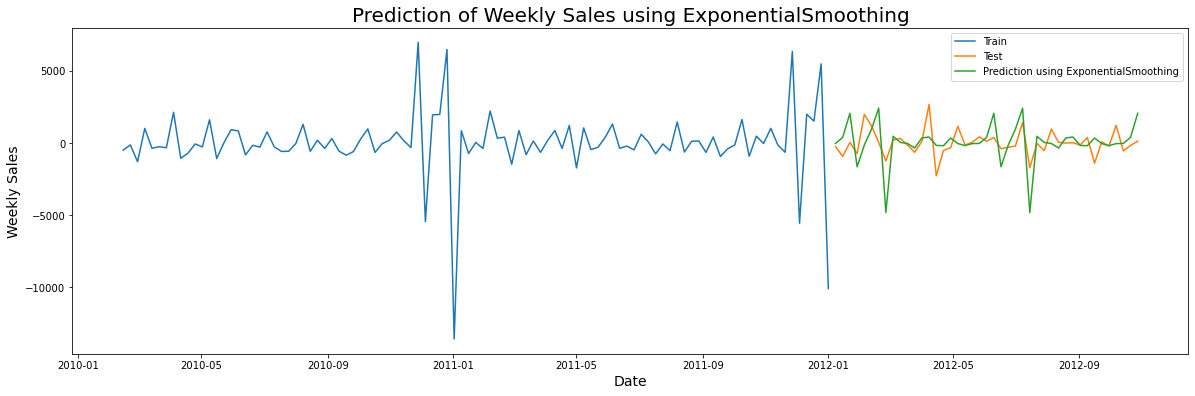

In [105]:
model_exp_smoothing = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() 
y_pred = model_exp_smoothing.forecast(len(test_data_diff)

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [106]:
wmae_test(test_data_diff, y_pred)

840.681060966696

In [65]:
results = pd.DataFrame(columns=['Model','WMAE'])
results=results.append(
    {'Model': 'Linear Regressor',
     'WMAE' : wmae_LR},ignore_index=True)
results=results.append(
    {'Model': 'Decision Tree',
     'WMAE' : wmae_DT},ignore_index=True)
results=results.append(
    {'Model': 'Ridge Regression',
     'WMAE' : wmae_ridge},ignore_index=True)
results=results.append(
    {'Model': 'Ridge Regression',
     'WMAE' : wmae_lasso},ignore_index=True)


NameError: name 'wmae_LR' is not defined

In [175]:
accuracy(model_holt_winters)

NameError: name 'accuracy' is not defined